In [2]:
#@title Imports & Utils
#!pip install -q git+https://www.github.com/google/jax-md

import time

from functools import partial
import numpy as onp

import jax.numpy as np

from jax import jit, grad, vmap, value_and_grad, random, lax

from jax.example_libraries import stax
from jax.example_libraries import optimizers

from jax.config import config
config.update('jax_enable_x64', True)

from IPython.display import HTML, display

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Ellipse, Rectangle
from matplotlib.collections import PatchCollection
import networkx as nx


from jax_md import quantity, space, energy, minimize


f32 = np.float32
f64 = np.float64


/tmp/ipykernel_3354/1785026392.py:16: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [18]:
def circles(x, y, s, c='b', vmin=None, vmax=None, **kwargs):
    """
    Make a scatter plot of circles. 
    Similar to plt.scatter, but the size of circles are in data scale.
    Parameters
    ----------
    x, y : scalar or array_like, shape (n, )
        Input data
    s : scalar or array_like, shape (n, ) 
        Radius of circles.
    c : color or sequence of color, optional, default : 'b'
        `c` can be a single color format string, or a sequence of color
        specifications of length `N`, or a sequence of `N` numbers to be
        mapped to colors using the `cmap` and `norm` specified via kwargs.
        Note that `c` should not be a single numeric RGB or RGBA sequence 
        because that is indistinguishable from an array of values
        to be colormapped. (If you insist, use `color` instead.)  
        `c` can be a 2-D array in which the rows are RGB or RGBA, however. 
    vmin, vmax : scalar, optional, default: None
        `vmin` and `vmax` are used in conjunction with `norm` to normalize
        luminance data.  If either are `None`, the min and max of the
        color array is used.
    kwargs : `~matplotlib.collections.Collection` properties
        Eg. alpha, edgecolor(ec), facecolor(fc), linewidth(lw), linestyle(ls), 
        norm, cmap, transform, etc.
    Returns
    -------
    paths : `~matplotlib.collections.PathCollection`
    Examples
    --------
    a = np.arange(11)
    circles(a, a, s=a*0.2, c=a, alpha=0.5, ec='none')
    plt.colorbar()
    License
    --------
    This code is under [The BSD 3-Clause License]
    (http://opensource.org/licenses/BSD-3-Clause)
    """

    if np.isscalar(c):
        kwargs.setdefault('color', c)
        c = None

    if 'fc' in kwargs:
        kwargs.setdefault('facecolor', kwargs.pop('fc'))
    if 'ec' in kwargs:
        kwargs.setdefault('edgecolor', kwargs.pop('ec'))
    if 'ls' in kwargs:
        kwargs.setdefault('linestyle', kwargs.pop('ls'))
    if 'lw' in kwargs:
        kwargs.setdefault('linewidth', kwargs.pop('lw'))
    # You can set `facecolor` with an array for each patch,
    # while you can only set `facecolors` with a value for all.

    zipped = onp.broadcast(x, y, s)
    patches = [Circle((x_, y_), s_)
               for x_, y_, s_ in zipped]
    collection = PatchCollection(patches, **kwargs)
    if c is not None:
        c = onp.broadcast_to(c, zipped.shape).ravel()
        collection.set_array(c)
        collection.set_clim(vmin, vmax)

    ax = plt.gca()
    ax.add_collection(collection)
    ax.autoscale_view()
    plt.draw_if_interactive()
    if c is not None:
        plt.sci(collection)
    return collection

In [17]:
def species_sigma(diameters):
    diameter_matrix = np.tile(diameters, (diameters.shape[0],1)) 
    return 0.5* (diameter_matrix + diameter_matrix.T)

def box_size_at_packing_fraction(diameters, species, packing_fraction):
    
    bubble_volume = np.sum(np.pi * (diameters[species]**2)/4)
    return np.sqrt(bubble_volume / packing_fraction)

def simulation(diameters, packing_fraction, key, simulation_steps):
  box_size = box_size_at_packing_fraction(diameters, species, packing_fraction)
  displacement, shift = space.periodic(box_size)

  sigma = species_sigma(diameters)
  energy_fn = energy.soft_sphere_pair(
      displacement, species=species, sigma=sigma)

  pos_key, sim_key = random.split(key)

  R = random.uniform(pos_key, (N, 2), maxval=box_size)

  init_fn, apply_fn = minimize.fire_descent(energy_fn, shift)
  state = init_fn(R)

  do_step = lambda state, t: (apply_fn(state, t=t), ())
  state, _ = lax.scan(do_step, state, simulation_steps)

  return box_size, energy_fn(state.position), state.position, displacement, shift

def simulate_and_show(diameters, packing_fraction):
    key = random.PRNGKey(0)
    simulation_steps = np.arange(500)
    box_size, raft_energy, R, displacement, shift = simulation(diameters, packing_fraction, key, simulation_steps)
    fig_length = 5 #inches
    dots_per_inch = 100
    fig, ax = plt.subplots(figsize=(fig_length, fig_length), dpi = dots_per_inch)
    R = R- box_size* np.rint(R/box_size)
    circles(R[:,0],R[:,1], 0.5*diameters[species], fc = 'None', ec = 'k')
    ax.axis('equal')
    return box_size, raft_energy, R, displacement, shift

def createGraphFromPositions(N, R, diameters, species, box_size, displacement):
    X = onp.array(R, dtype = np.float64)
    r_c = 0.5*( onp.tile(diameters[species],(N,1)) + onp.tile(diameters[species],(N,1)).T)
    distances = np.linalg.norm(space.map_product(displacement)(R,R), axis =2)

    E1=onp.array(np.where(distances<r_c))
    E=onp.transpose(E1[:,E1[0]>E1[1]])
    
    G = nx.Graph()
    G.add_nodes_from(range(N))
    G.add_edges_from(E)
    E = onp.array(G.edges)
    L = np.linalg.norm(space.map_bond(displacement)(R[E[:, 0],:],R[E[:, 1],:]))
    if np.sum(L<0.1)>0:
        print('issue')
    return N, G, X, E
    



In [73]:
class System:
    def __init__(self, nr_points, k_angle, random_seed, r_circle, dx, periodic = False):
        self.nr_points = nr_points #per side
        self.random_seed = random_seed
        self.r_circle = r_circle
        self.dx = dx
        self.k_angle = k_angle


        #penalty parameters: node and bond crossing: 
        
        #node energy attrbutes 
        self.soft_sphere_sigma = 0.3 #diameter
        self.soft_sphere_epsilon = 2.0 

        #crossing penalty attributes
        self.crossing_penalty_threshold = 0.3 #radians
        self.crossing_penalty_strength = 2.0 # epsilon of soft angle strength
        
        self.penalty_scale = 1e-5 #per node penalty energy that scales to 1 unit in objective functions

        self.k_std_threshold = 1.0
        self.k_std_strength = 2.0
       
        
        # Initialize attributes
        self.N = None
        self.G = None
        self.X = None
        self.E = None
        self.L = None
        self.surface_nodes = None  
        self.surface_mask = None
        self.surface_bond_mask = None  #not being used
        self.mass = None
        self.spring_constants = None
        self.distances = None
        self.angle_triplets = None
        self.initial_angles = None
        self.displacement = None
        self.shift = None
        
        # Acoustic properties
        self.m = None
        self.frequency_center = None
        self.frequency_width = None
        self.ageing_rate = 0.01
        self.success_fraction = 0.05
        self.nr_trials = None
        self.degrees = None
        
        # Auxetic properties
        self.perturbation = 1.
        self.delta_perturbation = 0.1
        self.steps = 50
        self.write_every = 1


    def create_periodic_graph(self):
        # Initialize JAX PRNGKey
        key = random.PRNGKey(self.random_seed)

        #set number of particles
        N = self.nr_points ** 2 
        N_4 = N // 4
        self.N = N


        #set up bubble simulation
        packing_fraction = 1.1
        diameters = np.array([1.0, 0.87, 0.74, 0.60]) #**self.dx we could add this functionality, where dx in this case would amplify the polydispersity 
        simulation_steps = 500
        
        species = np.array([0] * (N_4) + [1] * (N_4) + [2] * (N_4) + [3] * (N - 3*N_4), dtype=np.int32)
        
        
        
        # Split the key for the next random operation
        key, subkey = random.split(key)
        


        box_size = np.sqrt(np.sum (np.pi * (diameters[species]**2)/4)  / packing_fraction)
        
        displacement, shift = space.periodic(box_size)
        self.displacement = displacement
        self.shift = shift


        diameter_matrix = np.tile(diameters, (diameters.shape[0],1)) 
        sigma = 0.5* (diameter_matrix + diameter_matrix.T)

        
        energy_fn = energy.soft_sphere_pair(
          displacement, species=species, sigma=sigma)
        
        pos_key, sim_key = random.split(key)
        
        initial_positions = random.uniform(pos_key, (self.N, 2), maxval=box_size)
        
        init_fn, apply_fn = minimize.fire_descent(energy_fn, shift)
        state = init_fn(initial_positions)
        
        do_step = lambda state, t: (apply_fn(state, t=t), ())

        
        state, _ = lax.scan(do_step, state, np.arange(simulation_steps))

        R = state.position
        
        
        r_c = 0.5*( np.tile(diameters[species], (self.N,1)) + np.tile(diameters[species],(self.N,1)).T)
        distances = np.linalg.norm(space.map_product(self.displacement)(R,R), axis =2)

        E1=onp.array(np.where(distances<r_c))
        E=onp.transpose(E1[:,E1[0]>E1[1]])
        
        G = nx.Graph()
        G.add_nodes_from(range(self.N))
        G.add_edges_from(E)
        E = onp.array(G.edges)
        L = np.linalg.norm(space.map_bond(self.displacement)(R[E[:, 0],:],R[E[:, 1],:]))
        
        if np.sum(L<0.1)>0:
            print('bubbles are superimposed! reduce packing fraction')
        
        
        
        
        
        
        

        self.G = G
        self.X = R
        self.E = E
        self.L = L
        
        
        #self.get_mass()
        self.degrees  = np.array([val for (node, val) in G.degree()])
    

        

In [74]:
def plotGraph(N,G,X):
    fig_length = 5 #inches
    dots_per_inch = 100
    fig, ax = plt.subplots(figsize=(fig_length, fig_length), dpi = dots_per_inch)
    pos = {i: (X[i, 0], X[i, 1]) for i in range(N)}
    nx.draw_networkx_edges(G,pos)
    plt.axis('equal')
    return

In [75]:
system =System(20, 2.0, 65, 2.0, 2.0)

In [76]:
system.create_periodic_graph()
np.mean(np.transpose(np.array(G.degree()))[1])

Array(5.7475, dtype=float64)

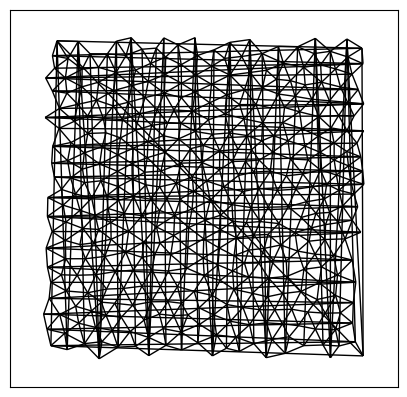

In [67]:
plotGraph(system.N, system.G, system.X)

In [82]:
np.linalg.norm(space.map_bond(system.displacement)(system.X[system.E[:, 0],:],system.X[system.E[:, 1],:]), axis =1)

Array([0.77441471, 0.88716754, 0.79319667, ..., 0.58488882, 0.59161437,
       0.54539794], dtype=float64)

Array(4, dtype=int64)

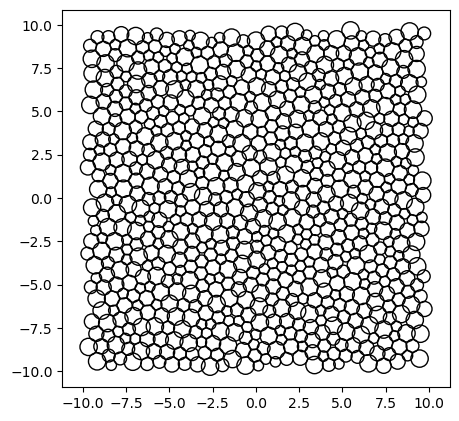

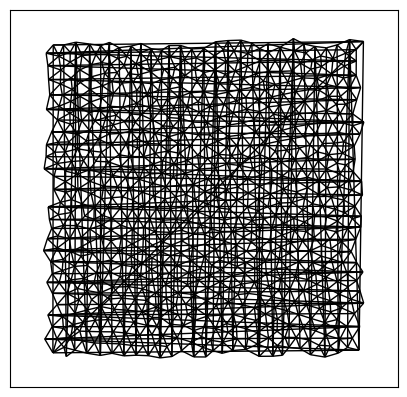

In [19]:
N = 4*200
N_2 = N // 4
packing_fraction = 1.1


diameters = np.array([1.0, 0.87, 0.74, 0.60])

species = np.array([0] * (N_2) + [1] * (N_2) + [2] * (N_2) + [3] * (N_2), dtype=np.int32)

box_size, raft_energy, R, displacement, shift = simulate_and_show(diameters, packing_fraction)
N, G, X, E = createGraphFromPositions(N, R, diameters, species,box_size, displacement)
plotGraph(N,G,X)
np.min(np.transpose(np.array(G.degree()))[1]) #degrees

In [54]:
np.linalg.norm(space.map_product(displacement)(R,R), axis =2).shape

(400, 400)

In [58]:
r_c = 0.5*( onp.tile(diameters[species],(N,1)) + onp.tile(diameters[species],(N,1)).T)
distances = np.linalg.norm(space.map_product(displacement)(R,R), axis =2)
print(distances.shape)
E1=onp.array(np.where(distances<r_c))

(400, 400)


In [24]:
print(R[0,:],R[1,:],displacement(R[0,:],R[1,:]))


[-0.17647924 -2.64447568] [-4.69356673 -3.05266896] [4.51708749 0.40819329]


In [10]:
nx.check_planarity(G)

(False, None)

In [15]:
def simulate_compressed(compression, R, box_size, diameters, key, simulation_steps):
  box_size = box_size_at_packing_fraction(diameters, species, packing_fraction)
  displacement, shift = space.periodic(np.array([box_size,compression*box_size]))
  R_perturbed = R * [1, compression]
  sigma = species_sigma(diameters)
  energy_fn = energy.soft_sphere_pair(
      displacement, species=species, sigma=sigma)

  init_fn, apply_fn = minimize.fire_descent(energy_fn, shift)
  state = init_fn(R_perturbed)

  do_step = lambda state, t: (apply_fn(state, t=t), ())
  state, _ = lax.scan(do_step, state, simulation_steps)

  return box_size, energy_fn(state.position), state.position

Array(3, dtype=int64)

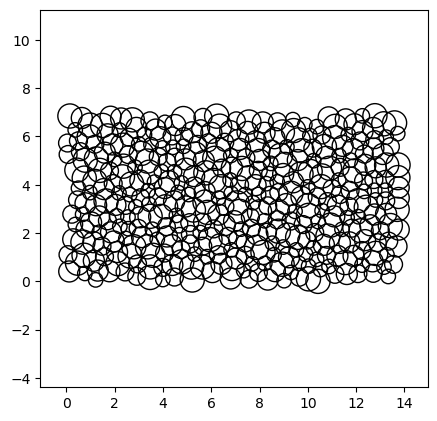

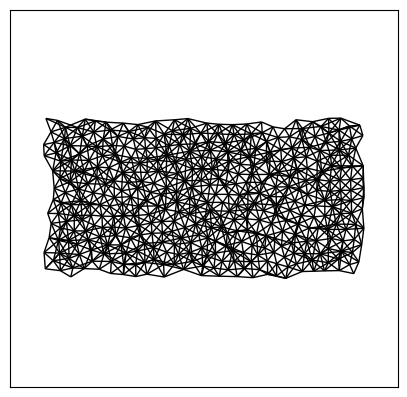

In [18]:
key = random.PRNGKey(0)
simulation_steps = np.arange(500)
box_size, raft_energy, R = simulate_compressed(0.5, X, box_size, diameters, key, simulation_steps)
fig_length = 5 #inches
dots_per_inch = 100
fig, ax = plt.subplots(figsize=(fig_length, fig_length), dpi = dots_per_inch)
#R = R- box_size* np.rint(R/box_size)
circles(R[:,0],R[:,1], 0.5*diameters[species], fc = 'None', ec = 'k')
ax.axis('equal')
N, G, X, E = createGraphFromPositions(N, R, diameters, species,box_size)
plotGraph(N,G,X)
np.min(np.transpose(np.array(G.degree()))[1]) #degrees